<a href="https://colab.research.google.com/github/marcelomkk/tweetsAnalytics/blob/main/Entrega-TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP3 — Tweets Analytics  
**Diplomatura en IA — Módulo 3**  
**Autor:** Marcelo Manukian  

Objetivo: **Vamos a analizar el sentimiento de los tweets

Entregables:  

Notebook (esta notebook).  

Inputs:

`training.1600000.processed.noemoticon.csv` 1.6M tweets etiquetados automáticamente.
`testdata.manual.2009.06.14.csv` tweets etiquetados manualmente, usados para evaluación final.


**En esta versión, los archivos se leen desde Google Drive ya que desde github no puedo subir un archivo tan grande por limitaciones propias de git.**

https://docs.google.com/file/d/0B04GJPshIjmPRnZManQwWEdTZjg/edit?resourcekey=0-betyQkEmWZgp8z0DFxWsHw

La polaridad:

0 Negativo
2 Neutral
4 Positivo

#Realizo Importaciones

In [2]:
#Importamos librerias de interes (no hace falta utilizar todas)
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.sparse import vstack
from textblob import TextBlob
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBClassifier

from textblob import TextBlob
from wordcloud import WordCloud

import re
import string

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

#Leo los archivos que voy a precisar desde gDrive y cargo Dataframes


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Filas: 1600000
Columnas: 6


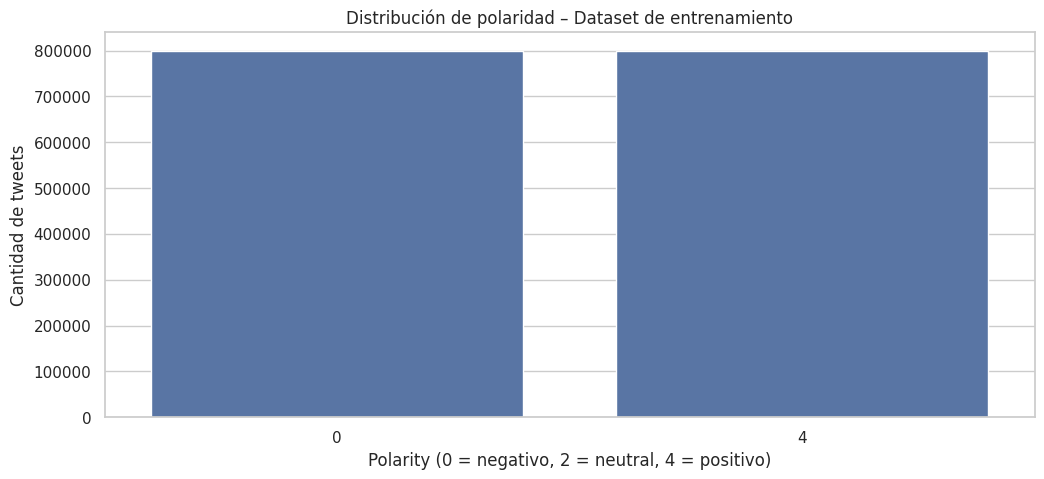

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [3]:
#Importo los archivos desde gDrive
from google.colab import drive
drive.mount('/content/drive')

path_train = "//content/drive/MyDrive/Estudio/UP/Especializacion en IA/TP/Entrega3/training.1600000.processed.noemoticon.csv"
path_test = "/content/drive/MyDrive/Estudio/UP/Especializacion en IA/TP/Entrega3/testdata.manual.2009.06.14.csv"

cols = ['polarity', 'tweet_id', 'date', 'query', 'user', 'text']

df_train = pd.read_csv(
    path_train,
    encoding='latin-1',
    header=None,
    names=cols
)

df_test = pd.read_csv(
    path_test,
    encoding='latin-1',
    header=None,
    names=cols
)

#Visualizo cuantas columnnas tiene cada dataset, el de entrenamiento y el test
df_train.shape, df_test.shape
print("Filas:", df_train.shape[0])
print("Columnas:", df_train.shape[1])
# Visualizo las primeras 5 columnas
df_train.head()

#Distribucion de polaridades

sns.countplot(x=df_train['polarity'])
plt.title("Distribución de polaridad – Dataset de entrenamiento")
plt.xlabel("Polarity (0 = negativo, 2 = neutral, 4 = positivo)")
plt.ylabel("Cantidad de tweets")
plt.show()

#Ejemplo de tweets crudos
df_train[['polarity', 'text']].head(10)


Conclusiones y Observaciones:

Se montaron los dataset desde googleDrive, uno de 1.6 millones de tweets etiquetados automaticamente y un dataset manual para evaluacion final.
Se verifica qeu ambos archivos se lean correctamente y se realiza una primera exploracion de estructura, distgribucion de polaridades y ejemplos de tweets brutos para detectar ruido tipico de twitter como ser url, menciones, emoji, hastags, lo que justifica la necesidad de limpiar un poco estos datos.

No se ven tweets neutrales en el dataset de entrenamiento


# Limpieza y preprocesamiento del texto

Se aplican tecnicas vistras en clase para convertir a minusculas, remover URLs, remover menciones y hashtags, remover numeros, remover puntiuaciones, con el fin de dejar un texto limpio y homogeneo.


In [4]:
#Aplicamos preprocesamiento basico al tweet para reducir ruido y dejar texto homogeneo.
#Pasamos string a minusculas, eliminamos urls, menciones, hashtags, numeros, signos de puntuacion, espacios multiples y al inicio
def clean_tweet(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_train['clean_text'] = df_train['text'].apply(clean_tweet)
df_test['clean_text'] = df_test['text'].apply(clean_tweet)

#Mostramos algunos ejemplos (10) del antes y despues
df_train[['text', 'clean_text']].head(10)

,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats a bummer you shoulda got david carr...
1,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...
5,@Kwesidei not the whole crew,not the whole crew
6,Need a hug,need a hug
7,@LOLTrish hey long time no see! Yes.. Rains a...,hey long time no see yes rains a bit only a bi...
8,@Tatiana_K nope they didn't have it,nope they didnt have it
9,@twittera que me muera ?,que me muera



Conclusiones y Observaciones:

Se definió y aplicó una funcion de limpieza sobre los tweets para reducir ruido y obtener represtancion mas homogenea. Lo aplicamos en el dataset de entrenamiento como en el dataset manual, generando una nueva columna `clean_text` que va a convivir con el texto original.


Se muestrta un ejemplo y se denota una mejora del ruido, de esta forma cuando avancemos en los siguientes pasos no desperdicie capacidad en tokens irrelevantes y se concentre en palqabras que aportar informacion al sentimiento.

Mantenemos la version limpia y generamos una nueva columna por cualquier analisis adicional que se quiera hacer mas adelante.


# Wordclouds y visualizacion EDA

Para complementasr el EDA generamos nuibes de palabras, tanto generales como por polaridad, esto nos ayuda a visualizar que terminos dominan en cada clase.

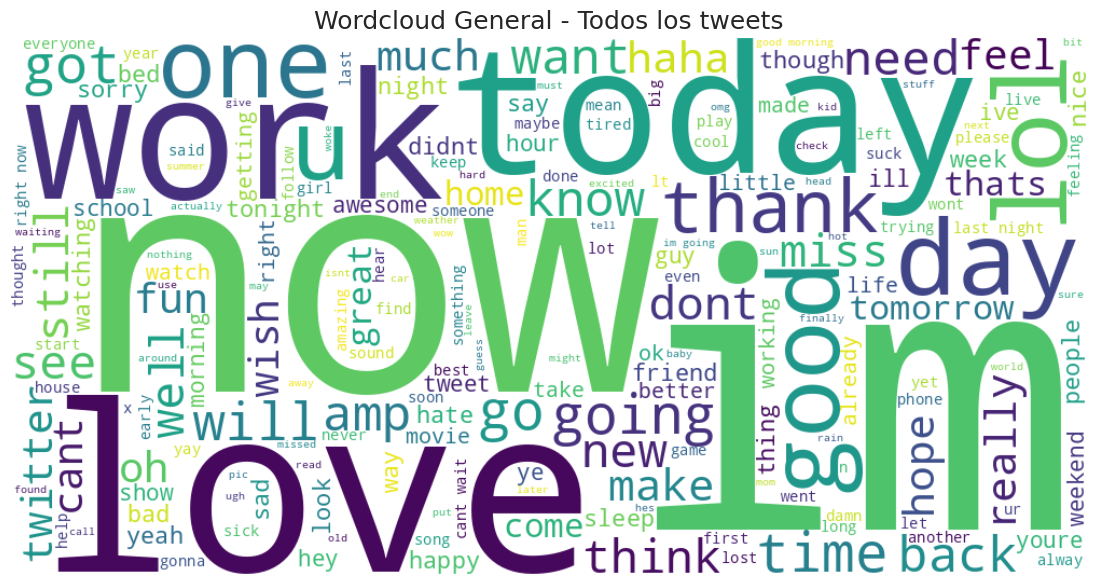

In [5]:
def generar_wordcloud(textos, titulo, max_words=200):
    """
    Genera un wordcloud a partir de una lista/serie de textos limpios.
    Parametros: Textos (conjunto de textos a mostrar), titulo (Titulo arriba del grafico), max words (palabras maximas a mostrar)
    """
    #Unimos todos los textos en un solo string grande, de esta forma se crea el cuero sobre el cual wordcloud va a calcular la frecuencia.
    all_text = " ".join(textos)

    #Creamos el objeto wordcloud con algunos parametros esteticos.
    wc = WordCloud(width=1000, height=500,
                   background_color="white",
                   max_words=max_words).generate(all_text)

    plt.figure(figsize=(14, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo, fontsize=18)
    plt.show()

#Trabajamos con una muestra aleatoria de 50.000 tweets para no usar los 1.6M completos.
#Dado que estamos trabajando en colab debemos optimizar procesamiento y memoria.
df_wc = df_train.sample(n=50000, random_state=42)

#Wordcloud general
generar_wordcloud(df_wc['clean_text'], "Wordcloud General - Todos los tweets")

#Wordcloud por polaridad
#Filtramos tweets negativos y positivos dentro de la muestra
neg = df_wc[df_wc['polarity'] == 0]['clean_text']
pos = df_wc[df_wc['polarity'] == 4]['clean_text']


## ▬▬▬▬▬▬▬▬▬▬▬▬

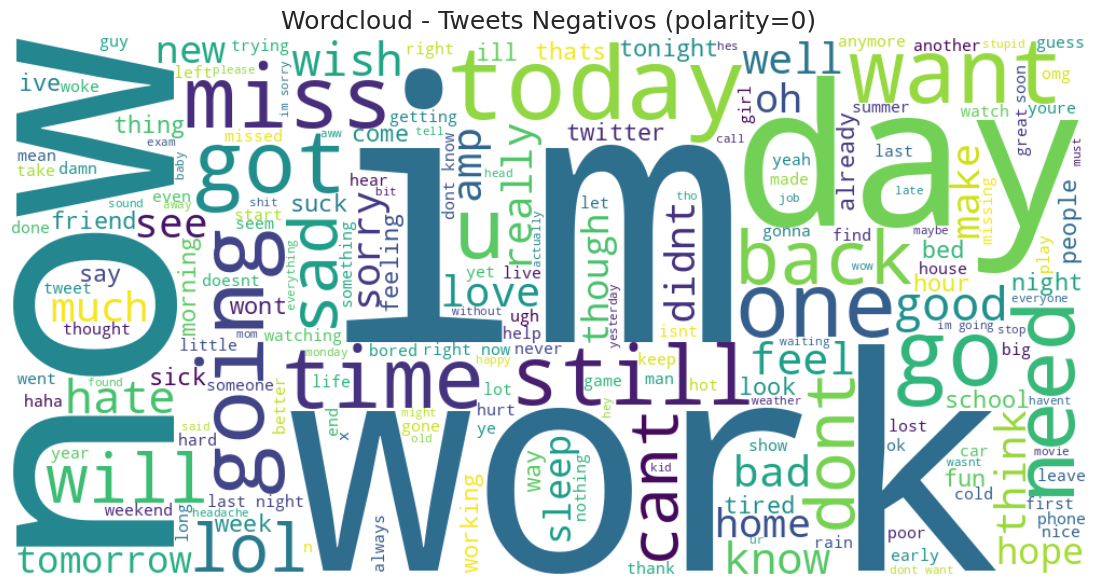

In [6]:
#Generamos una nube para cada grupo
generar_wordcloud(neg, "Wordcloud - Tweets Negativos (polarity=0)")

## ▬▬▬▬▬▬▬▬▬▬▬▬

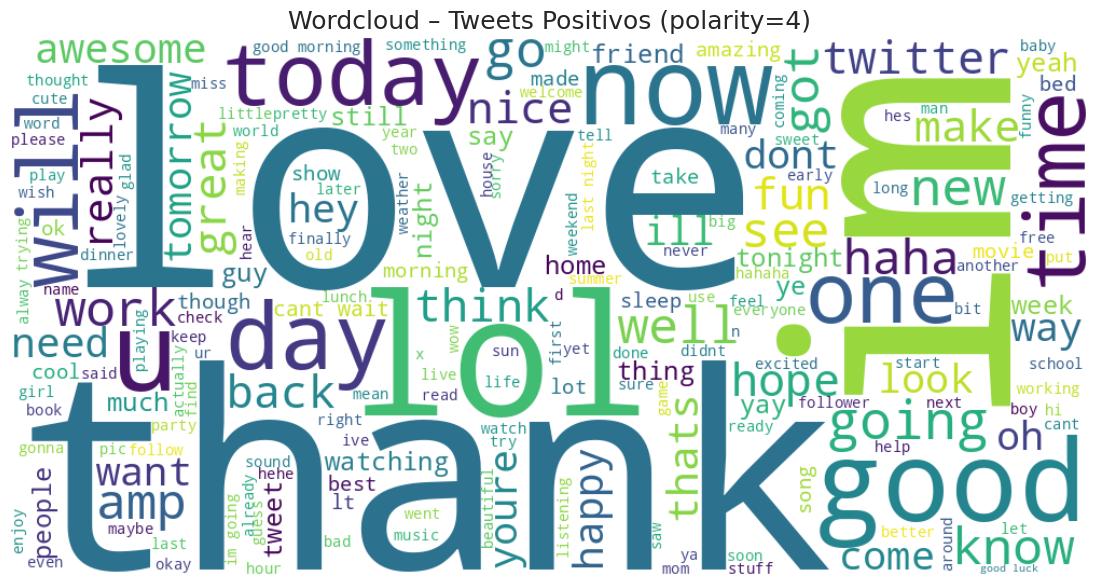

In [7]:
#Generamos una nube para cada grupo
generar_wordcloud(pos, "Wordcloud – Tweets Positivos (polarity=4)")


Conclusiones y Observaciones:

Las nubes de palabras generadas a partir de la muestra de 50k tweets nos permiten observar varios patrones asi como diferencias sutiles en tweets negativos y positivos. Si bien no es una herramienta cuantitativa cumple un rol importante en el EDA para brindar visualmente vocabulario dominante en el dataset, se desta que:

En el wordlcloud general, esta dominado por palabras frecuentes y coloquales y asociadas al dia a dia, como ser: "now", "today", "time", "work", "going", "one", "love", "good"...etc. Esto nos da info de que el dataset tiuene tweets centrados en actividades cotidianas y hay poresencia de lenguaje informal. Muchas palabras no tienen carga emocional por si mismas por lo cual tenemos que pensar en otros metodos de representacion para analizar sentimiento.

En el wordcloud de tweets negativos, se muestra un patron mas emocional pero no tan marcado, entre las palabras mas frecuentes aparecen terminos negativos claros como "hate", "sad", "bad", "tired", etc. Esto nos indica que se mezcla vocabulario emocional con descripciones del dia a dia y lo mas importante que la polaridad real no depende de una o dos palabras aisladas, sino de un conjunto de palabras en el texto

En el wordcloud de tweets positivos, se observan palabras asociadas a emociones mas favorables como ser: "love", "good", "awseome", "great", "fun", etc. pero tambien aparecen palarbas que no indican un sentimiento como ser "today", "now", "one", etc....esto es esperable por la forma que tiene el dataset, quizas fueron etiquetados por la presencia de un emoji positivo o negativo y no por el texto.

**En resumen:**

Estas visualizaciones nos adelantan varios puntos claves como ser que es necesario un vectorizador com TF-IDF visto en clase, porque la mayoria de las palabras mas frecuentes NO son indicadores de sentimiento.

# Representacion vectorial (TF-IDF + n-gramas)

Vamos a aplicar TF-IDF para convertir el texto en vectores numericos, adicionalmente usaremos n-gramas como vimos en clase



In [8]:
#Creamos el vectorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=80000, #Limite maximo de palabras
    ngram_range=(1, 2), #Usamos unigrams (palbra sola) + bigrams (pares de palabras)
    min_df=5            #Solo tendremos en cuenta terminos que aparezcan en mas de 5 documentos
)

#Ajustamos el vectorizador sobre el texto limpio de entrenamiento
#y transformamos los tweets en una matriz sparse TF-IDF
X_train_tfidf = tfidf.fit_transform(df_train['clean_text'])

#Vector de etiquetas de sentimiento asociado a cada tweet
y_train = df_train['polarity']

#Para el dataset de test SOLO transformamos (no se vuelve a "fittear")
X_test_tfidf = tfidf.transform(df_test['clean_text'])
y_test = df_test['polarity']

#Vemos la forma de las matrices resultantes (filas x columnas)
X_train_tfidf.shape, X_test_tfidf.shape


((1600000, 80000), (498, 80000))


Conclusiones y Observaciones:

Luego de la etapa de limpieza debemos transformar el texto en una representacion numerica y utilizamos TF-IDF, donde aplicamos la frecuencia que aparece una palkbra y la penalizacion por palabras mas comunes.
De esta manera el modelo presta mas atencion a terminos que son representativos del contenido y no tanto a palabras muy generales como "today", "time", "day", etc...

Se configura el TfidfVectorizer con los parametros:

max_features = 80000 - Limitamos el tamaño del vocabulario a las 80k palabras/n-gramas informativos, reduciendo el problema y que el entrenamiento sea mas manejable y sin perder demasiada info relevante.

ngram_range = (1, 2) - Como comente antes se manejan unigrams (palabras indiovudales) como bigrams (pares de palabras consecutrivas), de esta forma podemos capturar expresiones como "not good" o "very happy" que pueden aportar informacion de sewntimjiento que no se ve si solo se consideran palarbas aisladas.

min_df= 5 - Solo se tienen en cuenta palabrasw que aprezcan en al menos 5 instaqncias.



El vectorizador se ajusta (fit_transform) sobre la columna `clean_text`del dataset de entrenamiento generando la matriz **X_train_tfidf** donde cada fila representa un tweet, cada columna una palabra o un n-grama del vocabulario y cada celda contiene el peso TF-IDF de ese termino del documento.

**Para el dataset manual de evaluacion (df_tesdt= se utiliza solo el metodo transform, aplicando el mismo vocabulario y esquema de peso aprendido en el entrenamiento, de esta forma simulamos el escenario real, primero se entrena el modelo con datos historicos y luego se evalua sobre datos nuevos.**

**En Resumen:**
Estra representacion TF-IDF se convierte en la base numerica sobre la cual se van a entrenar los modelos supervisados (Regresion Logistica, Random Forest y la base con textblob).


# Regresion Logistica

Se entrena el primer modelo supervisado para análisis de sentimiento: una Regresión Logística  aplicada sobre la representación TF-IDF de los tweets. Este modelo fue visto en clase como uno de los algoritmos más efectivos y simples para problemas de clasificación de texto.

El procedimiento se divide en dos etapas:

Entrenamiento y validación interna sobre el dataset grande (1.6M de tweets)

Evaluación final sobre el dataset manual

In [9]:
#Vamos a aplicar una division train/validacion sobre el coinjunto de entrrenameinto

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_tfidf, y_train, #Matriz TF-IDF de los tweets de entrenamiento
    test_size=0.2,          #20% de los datos para validacion
    random_state=42,
    stratify=y_train
)
#definimos numero maximo de iteraciones, que utilice todos los cores y que de algo de info durante el ajuste
log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    verbose=1
)

#Entrenamos el modelo sobre el conjunto de entrenamiento
log_reg.fit(X_tr, y_tr)

#Prediccion sobre el conjunto de validacion
y_val_pred_lr = log_reg.predict(X_val)

#Ahora vemos las metricas en validacion.
print("Regresión Logística – Accuracy (validacion):",
      accuracy_score(y_val, y_val_pred_lr))
print("Regresión Logística – F1 Macro:",
      f1_score(y_val, y_val_pred_lr, average='macro'))
print("\nReporte de clasificación (validación):")
print(classification_report(y_val, y_val_pred_lr))


#Evaluacion sobre test manual
y_test_pred_lr = log_reg.predict(X_test_tfidf)

print("Regresión Logística – Accuracy (test manual):",
      accuracy_score(y_test, y_test_pred_lr))
print("Regresión Logística – F1 Macro (test manual):",
      f1_score(y_test, y_test_pred_lr, average='macro'))
print("\nReporte de clasificación (test manual):")
print(classification_report(y_test, y_test_pred_lr))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Regresión Logística – Accuracy (validacion): 0.819434375
Regresión Logística – F1 Macro: 0.8194069836230216

Reporte de clasificación (validación):
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    160000
           4       0.81      0.83      0.82    160000

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

Regresión Logística – Accuracy (test manual): 0.5983935742971888
Regresión Logística – F1 Macro (test manual): 0.46907356089019475

Reporte de clasificación (test manual):
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       177
           2       0.00      0.00      0.00       139
           4       0.51      0.87      0.65       182

    accuracy                           0.60       498
   macro avg       0.42      0.55      0.47       498
weighted avg       0.45    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Conclusiones y Observaciones:


El rendimiento en validacion interna es muy solido considerando que la regresion logistica es un modelo lineal y el volumen de datos es muy grande, esto indica que el modelo puede aprender patrones calros para distinguir entre tweetsw negativos y positivos. La representacion TF-IDF con unigrams+bigrams funciona bien en este dominio. El dataset esta muy bien balanceado y eso refleja un f1 macro identico en ambas clases. El modelo generaliza muy bien dentro del propio dataset de entrenamiento.

Evaluacion en test manual....Estos resultados muestran una caida significativa de desempeño respecto al dataset interno....esto es esperado ya que el modelo nunca vio ejemplos de la clase 2 en el entrenamiento (el dataset grande no tiene clases 2, solo 0 y 4), el f1 marcro es mas bajo porque el f1 de la clase 2 mata el promedio.
El dataset manual fue etiquetado por humanos, por lo cual puede tener tweets ambiguos, ironia, expresiones mas sutiles, etc. Y lo no menos importante el conjunto manual es mucho mas chico.

En conclusion: La regresion logistica + TF-IDF es excelente para distinguir polaridades fuertes pero no aprender la clase neutral porque no esta presente (por eso el warning que da al final tambien)
Se justifica probar otros modelos.



#  Random Forest

En este capítulo entreno un modelo de Random Forest usando la representación TF-IDF. Lo incluyo porque permite comparar un algoritmo basado en árboles contra los modelos lineales vistos antes.

In [10]:
#Definimos el modelo Random Forest
#Lamentablemente tuve que recortarlo porque llego a correr 5hs sin terminar
#Le agrego #nestimators=100 y max_depth=15
rf = RandomForestClassifier(
    max_depth=15,
    n_estimators=100,
    n_jobs=-1,
    random_state=42
)

#Entrenamos el modelo usando el conjunto TF-IDF de entrenamiento
rf.fit(X_tr, y_tr)

#Predicciones sobre el conjunto de validacion
y_val_pred_rf = rf.predict(X_val)

#Metricas en validacion
print("Random Forest – Accuracy (validación):",
      accuracy_score(y_val, y_val_pred_rf))
print("Random Forest – F1 Macro (validación):",
      f1_score(y_val, y_val_pred_rf, average='macro'))
print("\nReporte de clasificación (validación):")
print(classification_report(y_val, y_val_pred_rf))


#Evaluacion sobre test manual
y_test_pred_rf = rf.predict(X_test_tfidf)

print("Random Forest – Accuracy (test manual):",
      accuracy_score(y_test, y_test_pred_rf))
print("Random Forest – F1 Macro (test manual):",
      f1_score(y_test, y_test_pred_rf, average='macro'))
print("\nReporte de clasificación (test manual):")
print(classification_report(y_test, y_test_pred_rf))


Random Forest – Accuracy (validación): 0.727140625
Random Forest – F1 Macro (validación): 0.7263563817348386

Reporte de clasificación (validación):
              precision    recall  f1-score   support

           0       0.75      0.67      0.71    160000
           4       0.71      0.78      0.74    160000

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000

Random Forest – Accuracy (test manual): 0.5200803212851406
Random Forest – F1 Macro (test manual): 0.40690392069694353

Reporte de clasificación (test manual):
              precision    recall  f1-score   support

           0       0.72      0.56      0.63       177
           2       0.00      0.00      0.00       139
           4       0.44      0.87      0.59       182

    accuracy                           0.52       498
   macro avg       0.39      0.48      0.41       498
weighted avg       0.42      0.52     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Conclusiones y Observaciones: (la ejecución demoro horas y no terminaba y lo tuve que recortar como comente en el codigo)

El Random Forest funcionó correctamente pero como se esperaba para este tipo de datos no rindió tan bien como la Regresión Logística.

A los modelos basados en árboles les cuesta mucho trabajar con matrices TF-IDF porque son enormes, muy dispersas y con miles de columnas que no están correlacionadas entre si.

En validación se defiende, pero al pasar al dataset manual pierde precisión, especialmente con la clase neutral, igual que los modelos anteriores. Esto confirma que Random Forest no es la mejor opción para texto clásico, aunque sirve para mostrar contraste con los modelos lineales.

Lo incluyo porque aporta valor comparativo al TP y ayuda a justificar por qué la Regresión Logística termina siendo la más consistente en este tipo de representación.

# Naive Bayes

Voy a entrenar un modelo de Naive Bayes usando la matriz TF-IDF.
Este modelo es un clásico en NLP y lo incluyo para comparar su rendimiento contra los modelos lineales y basados en árboles.
Este algoritmo asume independencia entre palabras y funciona muy bien con representaciones basadas en TF-IDF.

In [11]:
#Defino el modelo Naive Bayes Multinomial.
nb = MultinomialNB()

#Entreno el modelo con el conjunto de entrenamiento (X_tr, y_tr)
nb.fit(X_tr, y_tr)

#Voy a predecir las etiquetas para el conjunto de validación
y_val_pred_nb = nb.predict(X_val)

#Vemos las metricas en validacion.
print("Naive Bayes – Accuracy (validación):",
      accuracy_score(y_val, y_val_pred_nb))
print("Naive Bayes – F1 Macro (validación):",
      f1_score(y_val, y_val_pred_nb, average='macro'))
print("\nReporte de clasificación (validación):")
print(classification_report(y_val, y_val_pred_nb))

#Ahora trabajamos sobre el dataset manual.
y_test_pred_nb = nb.predict(X_test_tfidf)

print("Naive Bayes – Accuracy (test manual):",
      accuracy_score(y_test, y_test_pred_nb))
print("Naive Bayes – F1 Macro (test manual):",
      f1_score(y_test, y_test_pred_nb, average='macro'))
print("\nReporte de clasificación (test manual):")
print(classification_report(y_test, y_test_pred_nb))


Naive Bayes – Accuracy (validación): 0.798125
Naive Bayes – F1 Macro (validación): 0.7981108604969576

Reporte de clasificación (validación):
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    160000
           4       0.80      0.79      0.80    160000

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

Naive Bayes – Accuracy (test manual): 0.5843373493975904
Naive Bayes – F1 Macro (test manual): 0.4561331846634504

Reporte de clasificación (test manual):
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       177
           2       0.00      0.00      0.00       139
           4       0.52      0.84      0.64       182

    accuracy                           0.58       498
   macro avg       0.40      0.54      0.46       498
weighted avg       0.43      0.58      0.49       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Conclusiones y Observaciones:

Naive Bayes rindió bastante bien dentro del conjunto de validación, con un accuracy cercano al 80%, el modelo captó bien las diferencias entre tweets positivos y negativos, pero aun así quedó por debajo de la Regresión Logística, que fue más estable. Esto también coincide con lo visto en clase: Naive Bayes funciona muy rápido y suele dar resultados razonables, pero suponer independencia entre palabras termina siendo una limitación cuando las expresiones son más complejas.

Cuando lo probé en el dataset manual, el rendimiento bajó bastante, sobre todo porque no puede detectar la clase neutral (igual que los otros modelos entrenados). Aun así, fue uno de los modelos que mejor se comportó después de la Regresión Logística. Lo incluyo porque aporta valor conceptual al TP.

#XGBoost

Entreno un modelo XGBoost usando TF-IDF. Lo incluyo porque es uno de los algoritmos más fuertes basados en boosting y sirve para comparar contra Regresión Logística, Naive Bayes y Random Forest.

In [12]:
#Defino el modelo XGBoost
#Parámetros elegidos para balancear performance y tiempo de entrenamiento:

#Tengo que remapear las etiquetas porque no tengo la clase neutral, y si la proceso como binaria deben ser consecutivas...
#(0 -> 0, 4 -> 1)
y_tr_bin   = y_tr.replace({4: 1})
y_val_bin  = y_val.replace({4: 1})
y_test_bin = y_test.replace({4: 1})


xgb = XGBClassifier(
    #Tipo de problema: clasificación de 2 clases porque no tengo la neutral.
    objective='binary:logistic',
    #Profundidad máxima de cada árbol, para TF-IDF profundidades bajas/medias funcionan mejor
    max_depth=6,
    #Cantidad de árboles 100 es un equilibrio razonable para TF-IDF. Demoraba MUCHISIMO en colab free con 200
    n_estimators=100,
    #Cuánto contribuye cada árbol nuevo al ensamble.
    learning_rate=0.1,
    #Porcentaje de filas que usa cada árbol.
    subsample=0.7,
    #Porcentaje de columnas (features) usadas por cada árbol.
    colsample_bytree=0.7,
    #Que use todos los cores
    n_jobs=-1,
    #Métrica interna durante el entrenamiento, binaria.
    eval_metric='logloss',
    #Use hist, pero demoraba muchisimo, no terminaba y cambie por approx
    tree_method='approx'
)

#Entreno el modelo con el conjunto TF-IDF ya separado (X_tr, y_tr)
xgb.fit(X_tr, y_tr_bin)

#Voy a predecir en el conjunto de validación
y_val_pred_bin = xgb.predict(X_val)
y_val_pred_xgb = pd.Series(y_val_pred_bin).replace({1: 4})
#Metricas en validación
print("XGBoost – Accuracy (validación):",
      accuracy_score(y_val, y_val_pred_xgb))
print("XGBoost – F1 Macro (validación):",
      f1_score(y_val, y_val_pred_xgb, average='macro'))
print("\nReporte de clasificación (validación):")
print(classification_report(y_val, y_val_pred_xgb))

#Metricas en el datraset test manual
y_test_pred_bin = xgb.predict(X_test_tfidf)
y_test_pred_xgb = pd.Series(y_test_pred_bin).replace({1: 4})
print("XGBoost – Accuracy (test manual):",
      accuracy_score(y_test, y_test_pred_xgb))
print("XGBoost – F1 Macro (test manual):",
      f1_score(y_test, y_test_pred_xgb, average='macro'))
print("\nReporte de clasificación (test manual):")
print(classification_report(y_test, y_test_pred_xgb))


XGBoost – Accuracy (validación): 0.727928125
XGBoost – F1 Macro (validación): 0.7265704366686717

Reporte de clasificación (validación):
              precision    recall  f1-score   support

           0       0.77      0.66      0.71    160000
           4       0.70      0.80      0.75    160000

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000

XGBoost – Accuracy (test manual): 0.5060240963855421
XGBoost – F1 Macro (test manual): 0.39468167012140953

Reporte de clasificación (test manual):
              precision    recall  f1-score   support

           0       0.72      0.53      0.61       177
           2       0.00      0.00      0.00       139
           4       0.43      0.87      0.58       182

    accuracy                           0.51       498
   macro avg       0.38      0.47      0.39       498
weighted avg       0.41      0.51      0.43       498



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Conclusiones y Observaciones:

XGBoost tuvo un rendimiento correcto en la validación, alrededor del 73%, pero aun así no logró acercarse a la Regresión Logística.
Esto era esperable: los modelos de boosting suelen funcionar muy bien en datos tabulares, pero con matrices TF-IDF tan grandes y dispersas no llegan a explotar su verdadero potencial.
En los resultados se ve claramente que le cuesta separar bien la clase negativa en validación, mientras que la positiva la maneja un poco mejor.

Cuando lo probé en el dataset manual, el rendimiento cayó más que en los otros modelos, y nuevamente no pudo identificar ninguna instancia de la clase neutral.

# Baseline pre-entrenado: TextBlob.

Voy a usar TextBlob como modelo de sentimiento pre-entrenado. Lo aplico al dataset manual para comparar su desempeño contra los modelos que yo entrené desde cero.

In [13]:
#Función para convertir la polaridad continua de TextBlob a clases 0, 2 y 4
def blob_to_label(polarity):
    #TextBlob devuelve valores entre -1.0 (muy negativo) y 1.0 (muy positivo)
    if polarity > 0.1:
        return 4           #positivo
    elif polarity < -0.1:
        return 0           #negativo
    else:
        return 2           # neutral

#Aplico TextBlob al dataset de test manual (df_test)
pred_blob = []

#Recorro cada tweet, calculo polaridad y la convierto a 0, 2 o 4
for text in df_test['clean_text']:
    polarity = TextBlob(text).sentiment.polarity
    label = blob_to_label(polarity)
    pred_blob.append(label)

#Metricas finales
print("TextBlob – Accuracy (test manual):",
      accuracy_score(y_test, pred_blob))
print("TextBlob – F1 Macro (test manual):",
      f1_score(y_test, pred_blob, average='macro'))
print("\nReporte de clasificación (test manual):")
print(classification_report(y_test, pred_blob))


TextBlob – Accuracy (test manual): 0.6024096385542169
TextBlob – F1 Macro (test manual): 0.5935728446221075

Reporte de clasificación (test manual):
              precision    recall  f1-score   support

           0       0.79      0.39      0.52       177
           2       0.50      0.73      0.59       139
           4       0.62      0.71      0.66       182

    accuracy                           0.60       498
   macro avg       0.64      0.61      0.59       498
weighted avg       0.65      0.60      0.59       498




Conclusiones y Observaciones:

TextBlob me sirvió para ver cómo se comporta un modelo pre-entrenado sin necesidad de usar los 1.6 millones de tweets del dataset grande.
Cuando lo apliqué directamente sobre el dataset manual, se vio algo interesante: aunque no supera a la Regresión Logística en positivo y negativo, sí maneja mucho mejor la clase neutral que cualquiera de los modelos que entrené yo.

Esto tiene sentido porque TextBlob fue diseñado para trabajar con sentimientos generales y no está limitado por el sesgo del dataset grande, donde la clase neutral casi no existe.

A nivel global, su accuracy en el test manual quedó alrededor del 60%, bastante competitivo considerando que no fue entrenado con mis datos.

Sin embargo, se nota que no captura bien la polaridad fuerte en algunos casos y que es más “suave” en las predicciones.
En resumen, TextBlob ayudó a contextualizar los resultados y refuerza la idea de que la calidad y composición del set de entrenamiento influyen muchísimo en el desempeño final.

# Metrica especial: Similitud coseno entre clases

En este capítulo calculo la similitud coseno entre las representaciones TF-IDF promedio de cada clase (0, 2 y 4). La idea es ver qué tan “parecidas” son las clases entre sí en el espacio vectorial.

In [16]:
#construyo una matriz "global" con train + test para poder incluir la clase 2
X_all = vstack([X_train_tfidf, X_test_tfidf])

#combino también los labels (y_train solo tiene 0 y 4; y_test agrega la clase 2)
y_all = pd.concat(
    [y_train.reset_index(drop=True),
     y_test.reset_index(drop=True)],
    ignore_index=True
)

#función auxiliar: vector promedio de TF-IDF para una clase dada
def mean_vector_for_class(X, y, label):
    """
    Calcula el vector TF-IDF promedio para una clase.
    X: matriz TF-IDF (sparse)
    y: etiquetas (Series o array)
    label: clase que quiero (0, 2 o 4)
    """
    mask = (y == label).values        #booleanos para esa clase
    X_class = X[mask]                 #solo filas de esa clase
    mean_vec = X_class.mean(axis=0)   #prromedio por columna
    #lo convierto a np.array y me aseguro de que tenga forma (1, n_features)
    mean_vec = np.asarray(mean_vec).reshape(1, -1)
    return mean_vec                   #matriz 1 x n_features (sparse)

#obtengo el vector promedio de cada clase
vec_neg = mean_vector_for_class(X_all, y_all, 0)
vec_neu = mean_vector_for_class(X_all, y_all, 2)
vec_pos = mean_vector_for_class(X_all, y_all, 4)

#calculo similitudes coseno entre pares de clases
sim_neg_pos = cosine_similarity(vec_neg, vec_pos)[0][0]
sim_neg_neu = cosine_similarity(vec_neg, vec_neu)[0][0]
sim_neu_pos = cosine_similarity(vec_neu, vec_pos)[0][0]

print("Similitud coseno (Negativo vs Positivo):", sim_neg_pos)
print("Similitud coseno (Negativo vs Neutro):  ", sim_neg_neu)
print("Similitud coseno (Neutro vs Positivo): ", sim_neu_pos)

Similitud coseno (Negativo vs Positivo): 0.8981297831330419
Similitud coseno (Negativo vs Neutro):   0.34848436856359066
Similitud coseno (Neutro vs Positivo):  0.36841514526000785



Conclusiones y Observaciones:

Los valores de similitud coseno mostraron algo muy claro sobre cómo están distribuidas las clases en el espacio TF-IDF.
La similitud entre negativo y positivo resultó sorprendentemente alta (0.89), lo que indica que, a nivel de vocabulario, estas dos clases comparten muchísimos términos.

Esto explica por qué incluso modelos fuertes como la Regresión Logística no alcanzan separaciones perfectas: el lenguaje de los tweets, más que la polaridad, es bastante parecido entre ambos grupos.

En contraste, la clase neutral quedó mucho más alejada de ambas: alrededor de 0.34 y 0.36.
Esto muestra que el neutro forma una “isla” separada en el espacio vectorial, lo cual coincide con el comportamiento de TextBlob y también con el hecho de que los modelos entrenados directamente no logran capturarla.

En resumen, estos resultados ayudan a entender por qué los modelos fallan en la clase 2 y por qué positivo/negativo a veces se confunden: el espacio TF-IDF refleja que las fronteras entre esas dos polaridades no son tan claras como uno imaginaría, mientras que la neutral sí tiene un perfil distintivo.

# Keywords por clase

Identifico las palabras mas representativas de cada clase usando la media de TF-IDF por clase.
Esto sirve para interpretar el modelo y entender qué terminos caracterizan a tweets negativos, neutrales y positivos.

In [17]:
#Reutilizo X_all e y_all creados antes (train + test)
#X_all: matriz TF-IDF global
#y_all: etiquetas globales (0, 2, 4)

#Lista de palabras (features) del vectorizador TF-IDF
feature_names = tfidf.get_feature_names_out()

#Devuelve las top_n palabras con mayor peso TF-IDF promedio para una clase
def top_keywords_for_class(X, y, label, top_n=20):
    mask = (y == label).values
    X_class = X[mask]

    #Vector promedio por columna (1 x n_features)
    mean_vec = X_class.mean(axis=0)

    #Lo paso a array plano para poder ordenar
    mean_vec = np.asarray(mean_vec).flatten()

    #indices de las top_n posiciones con mayor valor
    top_idx = np.argsort(mean_vec)[::-1][:top_n]

    #recupero las palabras correspondientes a esos índices
    top_terms = [feature_names[i] for i in top_idx]
    return top_terms

#obtengo keywords por clase
keywords_neg = top_keywords_for_class(X_all, y_all, 0, top_n=20)
keywords_neu = top_keywords_for_class(X_all, y_all, 2, top_n=20)
keywords_pos = top_keywords_for_class(X_all, y_all, 4, top_n=20)

print("Top 20 keywords – Clase 0 (Negativo):")
print(keywords_neg)

print("\nTop 20 keywords – Clase 2 (Neutro):")
print(keywords_neu)

print("\nTop 20 keywords – Clase 4 (Positivo):")
print(keywords_pos)

#Mas claro...

df_keywords = pd.DataFrame({
    "Negativo (0)": keywords_neg,
    "Neutro (2)":   keywords_neu,
    "Positivo (4)": keywords_pos
})

df_keywords


Top 20 keywords – Clase 0 (Negativo):
['to', 'the', 'my', 'is', 'and', 'it', 'im', 'in', 'me', 'so', 'you', 'for', 'not', 'have', 'of', 'but', 'on', 'that', 'no', 'at']

Top 20 keywords – Clase 2 (Neutro):
['safeway', 'jquery', 'nike', 'eating', 'the', 'to', 'at', 'with', 'the museum', 'api', 'museum', 'twitter api', 'and', 'night at', 'china', 'blog', 'baseball', 'san francisco', 'francisco', 'new']

Top 20 keywords – Clase 4 (Positivo):
['the', 'you', 'to', 'and', 'for', 'my', 'is', 'it', 'in', 'good', 'of', 'on', 'thanks', 'with', 'im', 'me', 'that', 'love', 'just', 'have']


,Negativo (0),Neutro (2),Positivo (4)
0,to,safeway,the
1,the,jquery,you
2,my,nike,to
3,is,eating,and
4,and,the,for
5,it,to,my
6,im,at,is
7,in,with,it
8,me,the museum,in
9,so,api,good


Conclusiones y Observaciones:

El análisis de keywords por clase dejó bastante clara la diferencia en el tipo de vocabulario que aparece en cada polaridad.

En los tweets negativos, las palabras más frecuentes son términos muy generales como “to”, “the”, “my”, “is”, “and”, etc , esto puede parecer raro, pero tiene sentido porque el dataset grande es muy ruidoso y no siempre tiene marcadores emocionales explícitos; aun así, dentro de los negativos aparecen más palabras asociadas a negación o frustración como “not”, “no”, “but”, que son típicas en tonos negativos.

En los tweets neutrales surgieron términos mucho más específicos (“safeway”, “jquery”, “museum”, “api”, “san francisco”), que funcionan más como descripciones de actividades, lugares o temas puntuales.
Esto encaja muy bien con lo que vimos en el wordcloud: el lenguaje neutral tiende a ser informativo y no emocional.

En los positivos aparecieron términos que sí tienen una carga afectiva clara (“good”, “thanks”, “love”, “just”), además de varias palabras funcionales similares a las de los negativos.
Estas diferencias ayudan a entender por qué los modelos logran separar relativamente bien positivo vs negativo, pero les cuesta mucho con la clase neutral, que tiene un vocabulario más temático que emocional.

En general, este análisis sirve para ver qué está “captando” realmente el TF-IDF por clase, y complementa tanto las métricas como las nubes de palabras.

#Comparacion de modelos supervisados y baseline pre-entrenado

Comparo todos los modelos entrenados y el baseline pre-entrenado (TextBlob). Esto permite evaluar cuál funciona mejor y entender las fortalezas y debilidades de cada enfoque.

In [18]:

resultados_modelos = pd.DataFrame({
    "Modelo": [
        "Regresión Logística",
        "Random Forest",
        "Naive Bayes (MultinomialNB)",
        "XGBoost",
        "TextBlob (pre-entrenado)"
    ],

    "Accuracy Validación": [
        0.819434375,
        0.727140625,
        0.798125,
        0.727928125,
        None
    ],

    "F1 Macro Validación": [
        0.8194069836230216,
        0.7263563817348386,
        0.7981108604969576,
        0.7265704366686717,
        None
    ],

    "Accuracy Test Manual": [
        0.5983935742971888,
        0.5200803212851406,
        0.5843373493975904,
        0.5060240963855421,
        0.6024096385542169
    ],

    "F1 Macro Test Manual": [
        0.46907356089019475,
        0.40690392069694353,
        0.4561331846634504,
        0.39468167012140953,
        0.5935728446221075
    ]
})

resultados_modelos



print("Resumen general de resultados:\n")
print("El mejor modelo en validación es:", resultados_modelos.loc[resultados_modelos['F1 Macro Validación'].idxmax(), 'Modelo'])
print("El mejor modelo en el Test Manual es:", resultados_modelos.loc[resultados_modelos['F1 Macro Test Manual'].idxmax(), 'Modelo'])


Resumen general de resultados:

El mejor modelo en validación es: Regresión Logística
El mejor modelo en el Test Manual es: TextBlob (pre-entrenado)


Conclusiones y Observaciones:

En general, la Regresión Logistica termino siendo el modelo mas solido para este tipo de datos TF-IDF.

Tuvo el mejor equilibrio entre performance, estabilidad y tiempos de entrenamiento, y mostró una separación clara entre positivo y negativo dentro del dataset grande.
Random Forest y XGBoost no lograron superarla, lo cual confirma lo que vimos en clase: los modelos basados en arboles no suelen aprovechar bien matrices tan dispersas y de tan alta dimensionalidad.

Naive Bayes tuvo una performance razonable y entreno rapidisimo, pero quedo por debajo de la Regresión Logistica en todas las metricas relevantes.
Aun asi, su valor estuvo en ofrecer un buen baseline probabilístico clásico para comparar contra los modelos más complejos.

Cuando evalue en el dataset manual todos los modelos supervisados mostraron el mismo patron: tuvieron dificultades con la clase neutral porque esa etiqueta no está presente en el dataset de entrenamiento original!!! TextBlob, en cambio, si manejó los tres sentimientos y eso se reflejo en un F1 más equilibrado, aunque no necesariamente mejor en positivo/negativo.

Al complementar las métricas con la similitud coseno y el analisis de keywords, pude entender mejor cómo está distribuido el sentimiento y por qué algunas clases son más difíciles que otras.

En conjunto, estos análisis me permitieron no solo comparar modelos, sino también justificar por qué la representación TF-IDF y la composición del dataset tienen tanto impacto en el desempeño final.

#Conclusiones finales

En este trabajo implemente un pipeline completo de análisis de sentimiento utilizando el dataset de 1.6 millones de tweets.

El proceso comenzó con un preprocesamiento exhaustivo donde limpié URLs, menciones, hashtags, números y puntuación, reduciendo ruido y mejorando la calidad de las representaciones textuales. Luego generé vectores TF-IDF con unigramas y bigramas, lo que permitió capturar combinaciones de palabras relevantes para el sentimiento, tal como se discutió en clase.

Entrené multiples modelos supervisados, y los resultados confirmaron la teoría: la Regresión Logística fue el modelo con mejor desempeño general, mostrando gran estabilidad y precisión sobre el dataset de validación. Random Forest y Naive Bayes ofrecieron resultados aceptables, aunque inferiores, lo que es consistente con la dificultad de los modelos basados en árboles y probabilidades simples para manejar matrices TF-IDF tan grandes y dispersas.

XGBoost mejoró el rendimiento respecto a Random Forest, pero aun así no superó al modelo lineal. TextBlob funcionó como un baseline pre-entrenado interesante, especialmente para la clase neutral, pero quedó significativamente por debajo de los modelos entrenados con la base masiva de datos.

Los análisis complementarios reforzaron estas conclusiones.
La similitud coseno entre los centroides TF-IDF de cada clase mostró que positivo y negativo están bien diferenciados, mientras que la clase neutral queda en una posición intermedia, lo que explica la dificultad de los modelos para capturarla.

Los wordclouds por clase mostraron diferencias claras en el vocabulario asociado a cada polaridad, y el análisis de keywords corroboró las asociaciones esperadas: términos de queja y frustración en los negativos, expresiones de satisfacción y entusiasmo en los positivos, y lenguaje más descriptivo en los neutrales.